# odMLtables scenarios

This tutorial is an implementation of the scenarios described in *Sprenger et al (?) odMLtables: A user-friendly approach for
managing metadata of neurophysiological
experiments, ?* The scenarios present a simple, but realistic use case of odML and odMLtables in an experimental lab and are a good start to getting to odMLtables. Modification of this jupyter notebook is highly encuraged and can serve as a starting point for your own metadata workflow. For a detailed description of the individual scenarios, see *Sprenger et al. (?)*.

To execute the steps of the tutorial, press *Ctrl + Enter* in the cell you want to execute.

### Scenario 1: How to generate a metadata template without programming language

This scenario describes how a template structure for daily data collection can be set up. The example used here is the measurement of basic attributes of a mouse. The measures collected on a single day can be listed in a table as shown below, where *'YYYY-MM-DD'* specifies the measurement date.

| Date       | Measure             | Value    | Unit | Type   |
|------------|---------------------|----------|------|--------|
| YYYY-MM-DD | Weight              |          | g    | float  |
|            | Water Intake        |          | ml   | float  |
|            | Breathing Frequency |          | bpm  | float  |
|            | Measured by         | John Doe |      | string |
|            | Comment             |          |      | string |

This table can be generated using any spreadsheet software. Possible formats supported by odMLtables are *.xls* and *.csv*. For simplicity, we generate a *.csv* file with the same content using Python here

In [1]:
score_sheet = \
"""Date,Measure,Value,Unit,Type
YYYY-MM-DD,Weight,,g,float
,Water Intake,,ml,float
,Breathing Frequency,,bpm,float
,Measured by, John Doe,,string
,Comment,,,string
"""
with open('score_sheet.csv', 'w+') as f:
    f.write(score_sheet)

This metadata template in *.csv* format can be converted to an odML file using odMLtables:

In [2]:
import odmltables as odt

def score_sheet_to_odml(csv_file):
    table = odt.OdmlTable()
    # specify experiment specific headers used
    table.change_header(Path=1, PropertyName=2, Value=3, DataUnit=4, odmlDatatype=5)
    table.change_header_titles(Path='Date',PropertyName='Measure', DataUnit='Unit', odmlDatatype='Type')

    # loading from csv format and saving in odML format
    table.load_from_csv_table(csv_file)
    table.write2odml(csv_file[:-4] + '.odml')
    
score_sheet_to_odml('score_sheet.csv')

The resulting odML file can be visualized in the browser using the `odml.xls` style sheet.

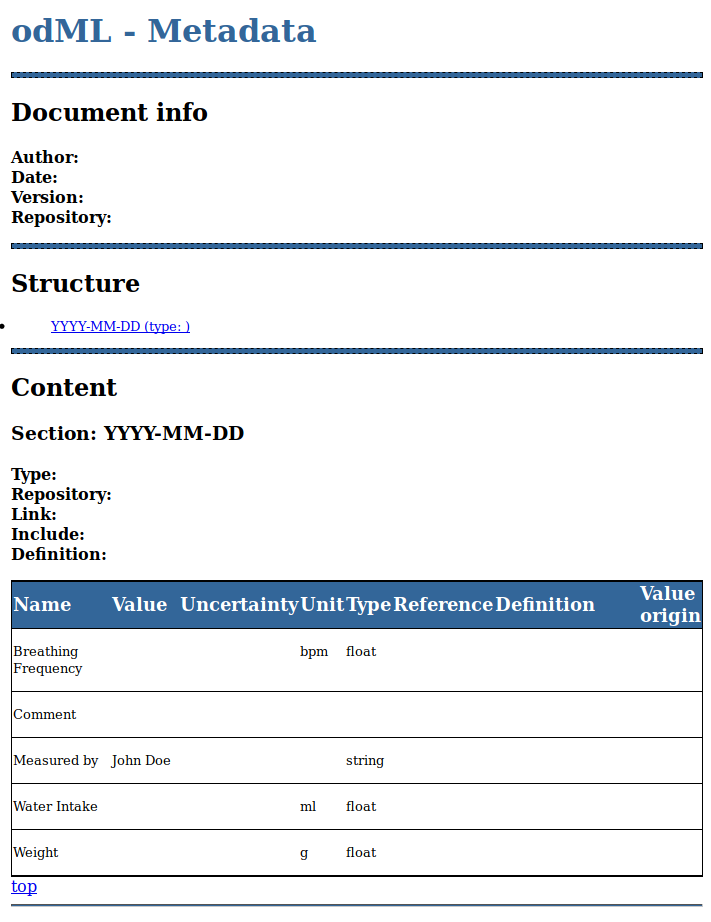

### Scenario 2: Collecting daily observations in a common odML structure

The template structure defined in `scenario 1` can now be copied for each measurement day and filled. The filled files will then be converted to odML and incorporated in a single odML file containing the complete metadata collected for an animal.

Here again we generate a filled metadata sheet in csv format using Python. In a real case this step would be performed using any spreadsheet software.

In [3]:
score_sheet1 = \
"""Date,Measure,Value,Unit,Type
2000-01-01,Weight,20.3,g,float
,Water Intake,5.21,ml,float
,Breathing Frequency,323,bpm,float
,Measured by, John Doe,,string
,Comment,Blood sample taken,,string
"""
with open('score_sheet_day1.csv', 'w+') as f:
    f.write(score_sheet1)

Since this is the only set of measurements availabe yet, we only need to convert it into the odML format as we did with the score sheet template in `scenario 1` and rename it because it is already the complete set of measurements at this point.

In [4]:
score_sheet_to_odml('score_sheet_day1.csv')

# renaming file, because this is the complete score sheet for now
import os
os.rename('score_sheet_day1.odml', 'score_sheet_complete.odml')

In the next step we aquire a second set of measurements, recorded on day 2. We directly convert the generated `csv` file into the odML format.

In [5]:
score_sheet2 = \
"""Date,Measure,Value,Unit,Type
2000-01-02,Weight,23.5,g,float
,Water Intake,6.89,ml,float
,Breathing Frequency,309,bpm,float
,Measured by, John Doe,,string
,Comment,small scratch at the right ear,,string
"""
with open('score_sheet_day2.csv', 'w+') as f:
    f.write(score_sheet2)
score_sheet_to_odml('score_sheet_day2.csv')

Now, we have two odML files for two subsequent recording days. To merge these into a single odML structure, we use the `merge` functionality provided by odMLtables. We expect the odML documents not to overlap, so we use the `stric` merge mode which raises errors for conflicting entries in the two odML files.

The measurement data of subsequent recordings days are added to the complete set stored in `score_sheet_complete.odml`.

In [6]:
def merge_score_sheets(file1, file2, mode='strict'):
    # loading first odML file and merge second into first
    table1 = odt.OdmlTable(file1)
    table1.merge(odt.OdmlTable(file2), mode=mode)
    table1.write2odml(file1)
    
merge_score_sheets('score_sheet_complete.odml',
                   'score_sheet_day2.odml')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '04f28739-37d1-4b47-ba77-71a447e1c36e', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:6:<section>]: missing element <type> within <section> tag{'oid': 'a3154c00-adda-461d-ad78-10f2b7a3ae7f', 'name': '2000-01-02', 'properties': <Property Weight>} (line 6)


### Scenario 3: How to filter a subset of an odML to edit it later on

For larger experiments the generated odML structure will grow in complexity. For easier visualization and modification / update of data we will generate an odML file which contains only a subset of the complete score sheet using the odML filter function.

In [7]:
def extract_subset(odML_file):
    table = odt.OdmlTable(odML_file)
    # extracting specific property based on property name and section name
    table.filter(SectionName='2000-01-01', PropertyName='Comment')
    table.write2odml('score_sheet_filtered.odml')
    
extract_subset('score_sheet_complete.odml')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '905b66ca-6a5b-49e3-84eb-10482bf9437b', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:43:<section>]: missing element <type> within <section> tag{'oid': '00e5164b-122e-45bb-ba72-bf5dd74d739c', 'name': '2000-01-02', 'properties': <Property Weight>} (line 43)


The next step could be to convert the filtered odML file into a csv file, update the necessary entries and convert it back into the odML format to finally merge the change back into the complete score sheet. For demonstration purposes here, we will modify the filtered odML file directly and merge it into the complete score sheet.

In [8]:
import odml
odmlfile = odml.fileio.load('score_sheet_filtered.odml')
odmlfile.sections['2000-01-01'].properties['Comment'].value = ['Blood sample shows no abnormalities']
odml.fileio.save(odmlfile, 'score_sheet_filtered.odml')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '260d3dab-26ce-48ac-9364-8f4b27284752', 'name': '2000-01-01', 'properties': <Property Comment>} (line 6)


### Scenario 4: Merging the edited subset back into the original structure

For merging the changes back into the complete score sheet we can use the same function as in `scenario 2`. In this case however, the entries of the two odML files overlap and we want to extend values in the first document by entries in the second one, so we merge using the `append` mode.

In [22]:
merge_score_sheets('score_sheet_complete.odml', 'score_sheet_filtered.odml', mode='strict')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '3e577716-d871-4484-91e0-ea65ed0469fe', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:43:<section>]: missing element <type> within <section> tag{'oid': '677746d1-d57c-4f24-a6f5-5a9d5cb255b1', 'name': '2000-01-02', 'properties': <Property Weight>} (line 43)
warning[None:6:<section>]: missing element <type> within <section> tag{'oid': 'd108322a-4352-4138-bc92-e471addd3659', 'name': '2000-01-01', 'properties': <Property Comment>} (line 6)


### Scenario 5: Create a tabular representation of the final merged odML for better viewing using the color options

For visualization of the metadata we convert the odML file to the tabular representation in the `.xls` format. This has the advantage of color support within the tabular structure. All color options can be customized using odMLtables.

In [11]:
def visualize_as_xls(odML_file):
    table = odt.OdmlXlsTable(odML_file)
    # optional: changing the color options in the output table
    table.first_marked_style.fontcolor = 'red'
    table.second_marked_style.fontcolor = 'red'
    # writing to xls format
    table.write2file(odML_file.split('.')[0] + '.xls')
    
visualize_as_xls('score_sheet_complete.odml')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '3e577716-d871-4484-91e0-ea65ed0469fe', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:43:<section>]: missing element <type> within <section> tag{'oid': '677746d1-d57c-4f24-a6f5-5a9d5cb255b1', 'name': '2000-01-02', 'properties': <Property Weight>} (line 43)


### Scenario 6: Compare entries in the odML via data screening, lab book tables

For many odML files a number of metadata structure are repeating within the file. Here, all metadata sections for the daily measurement have the same structure. For visualization and documentation purposes in labbooks an overview across these related structures is usefull and can be generated using the odMLtables `compare` function.

In [19]:
def generate_overview(odML_file, sections='all'):
    if sections=='all':
        sections = [s.name for s in odml.fileio.load(odML_file).sections]
    table = odt.compare_section_xls_table.CompareSectionXlsTable()
    table.load_from_file(odML_file)
    table.choose_sections(sections)
    #table.write2file()
    table.write2file(odML_file.split('.')[0] + '_overview.xls')
generate_overview('score_sheet_complete.odml')

warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '3e577716-d871-4484-91e0-ea65ed0469fe', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:43:<section>]: missing element <type> within <section> tag{'oid': '677746d1-d57c-4f24-a6f5-5a9d5cb255b1', 'name': '2000-01-02', 'properties': <Property Weight>} (line 43)
warning[None:6:<section>]: missing element <type> within <section> tag{'oid': '3e577716-d871-4484-91e0-ea65ed0469fe', 'name': '2000-01-01', 'properties': <Property Weight>} (line 6)
warning[None:43:<section>]: missing element <type> within <section> tag{'oid': '677746d1-d57c-4f24-a6f5-5a9d5cb255b1', 'name': '2000-01-02', 'properties': <Property Weight>} (line 43)


This generates an `xls` overview table comparing the first value entries for all selected sections.

### Scenario 7: Automatized processing of metadata collections

The workflow presented in `scenario 1 to 6` can be to some extend automatized using odMLtables. This simplifies the generation of an comprehensive metadata collection for the experimenter and makes the workflow more robust against human errors.

Here we start from a collection of daily csv sheets and generate a complete metadata collection as well as overview sheets from these.

In [13]:
# generating a number of score sheets for demonstration of workflow
import os
import numpy.random as random
def generate_dummy_data(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    for i in range(20):
        score_sheet = \
"""Date,Measure,Value,Unit,Type
2000-01-0{0},Weight,{1},g,float
,Water Intake,{2},ml,float
,Breathing Frequency,{3},bpm,float
,Measured by, John Doe,,string
,Comment,-,,string
""".format(i, random.uniform(low=19, high=25), random.uniform(low=5, high=7), random.uniform(low=300, high=400))
        with open(folder + '/score_sheet_day{}.csv'.format(i), 'w+') as f:
            f.write(score_sheet)
        
generate_dummy_data('./complete_workflow')

In [21]:
%%capture  --no-stdout
import warnings
warnings.filterwarnings('ignore')

# metadata workflow based on previously generated collection of csv files
import glob
def process_all_metadata(folder):
    # extract all metadata files present in this folder
    source_files = sorted(glob.glob(folder + '/score_sheet_day*.csv'))
    if not source_files:
        return None
    
    # converting first source file to add other files to
    score_sheet_to_odml(source_files[0])
    os.rename(source_files[0][:-4] + '.odml', folder + '/score_sheet_complete.odml')
    
    # converting all other source files
    for source_file in source_files[1:]:
        score_sheet_to_odml(source_file)
        merge_score_sheets(folder + '/score_sheet_complete.odml',
                           source_file[:-4] + '.odml',
                           mode='strict')
        
    # create visualization and comparison tables
    visualize_as_xls(folder + '/score_sheet_complete.odml')
    generate_overview(folder + '/score_sheet_complete.odml')
    
process_all_metadata('./complete_workflow')

# copying style sheet for visualization in browser
os.popen('cp odml.xsl ./complete_workflow/odml.xsl')